# Julia é rápido

Muitas vezes, benchmarks são usados para comparar linguagens. Esses benchmarks podem levar a longas discussões, primeiro sobre o que exatamente está sendo avaliado e, em segundo lugar, o que explica as diferenças. Essas perguntas simples às vezes podem ser mais complicadas do que você pode imaginar à primeira vista.

O objetivo deste notebook é que você veja um benchmark simples para si mesmo. Pode-se ler o notebook e ver o que aconteceu no Macbook Pro do autor com um Intel Core I7 de 4 núcleos, ou executar o notebook por conta própria.

(Este material começou como uma palestra maravilhosa de Steven Johnson no MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Esboço deste Notebook

- Defina a função de soma
- Implementações e benchmarking de soma em ...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Resumo dos benchmarks

# `sum`: Uma função fácil de entender

Considere a função **soma** `sum(a)`, que computa
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
onde $ n $ é o comprimento de `a`.

In [1]:
a = rand(10^7) # 1D vetor de números aleatórios, uniforme em [0,1)

10000000-element Array{Float64,1}:
 0.36935825816456713
 0.6299356140816499
 0.9613364915504974
 0.5645837377376126
 0.7306470739564983
 0.2360073133504479
 0.6774559027789515
 0.9035988689243728
 0.8558029014786086
 0.27050266847860205
 0.66921241704475
 0.25596532996252686
 0.9254946815310172
 ⋮
 0.566035754929566
 0.13320886549380817
 0.7538768460934266
 0.33013384119012334
 0.8220073872278832
 0.4608860641534309
 0.18700412727649884
 0.13777922290208489
 0.8771235282452234
 0.8206980059765601
 0.7951621853089541
 0.49006673372240317

In [2]:
sum(a)

4.999722166044835e6

O resultado esperado é $0,5 * 10^7$, uma vez que a média de cada entrada é 0,5

# Comparando algumas maneiras em algumas Linguagens

In [3]:
@time sum(a)

  0.011544 seconds (1 allocation: 16 bytes)


4.999722166044835e6

In [4]:
@time sum(a)

  0.010990 seconds (1 allocation: 16 bytes)


4.999722166044835e6

In [5]:
@time sum(a)

  0.011030 seconds (1 allocation: 16 bytes)


4.999722166044835e6

O `@time` macro pode gerar resultados ruidosos, então não é nossa melhor escolha para benchmarking!

Felizmente, Julia tem um pacote `BenchmarkTools.jl` para tornar o benchmarking fácil e preciso:

In [ ]:
# Usando o Pacote
# Adicionando o Pacote ("BenchmarkTools")

In [6]:
using BenchmarkTools  

#  1. A linguagem C

C costuma ser considerado o padrão ouro: difícil para o ser humano, bom para a máquina. Ficar dentro de um fator de 2 de C costuma ser satisfatório. No entanto, mesmo dentro de C, há muitos tipos de otimizações possíveis das quais um escritor ingênuo de C pode ou não tirar vantagem.

O autor atual não fala C, então ele não lê a célula abaixo, mas fica feliz em saber que você pode colocar código C em uma sessão Julia, compilá-la e executá-la. Observe que o `" "" `envolve uma string de várias linhas.

In [7]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # faça um arquivo temporário


# compilar para uma biblioteca compartilhada canalizando C_code para gcc
# (funciona apenas se você tiver o gcc instalado):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# definir uma função Julia que chama a função C:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [8]:
c_sum(a)

4.999722166044618e6

In [9]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [10]:
c_sum(a) - sum(a)  

-2.169981598854065e-7

In [ ]:
≈  # alias para a função `isapprox`

In [11]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


Agora podemos comparar o código C diretamente no Julia:

In [12]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     14.124 ms (0.00% GC)
  median time:      14.513 ms (0.00% GC)
  mean time:        14.596 ms (0.00% GC)
  maximum time:     18.055 ms (0.00% GC)
  --------------
  samples:          343
  evals/sample:     1

In [13]:
println("C: O tempo mais rápido foi $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 14.123898 msec


In [14]:
d = Dict()  # um "dicionário", ou seja, uma matriz associativa
d["C"] = minimum(c_bench.times) / 1e6  # em milissegundos
d

Dict{Any,Any} with 1 entry:
  "C" => 14.1239

In [15]:
using Plots
gr()

Plots.GRBackend()

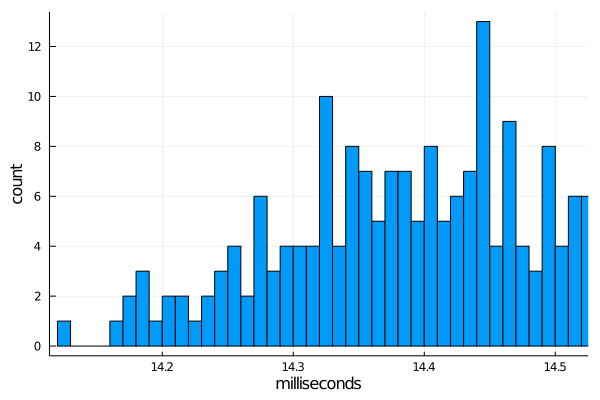

In [16]:
using Statistics # trazer suporte estatístico para desvios padrão
t = c_bench.times / 1e6 # vezes em milissegundos
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C com matemática rápida

Se permitirmos que C reorganize as operações de ponto flutuante, ele será vetorizado com instruções SIMD (instrução única, dados múltiplos).

In [17]:
const Clib_fastmath = tempname()   # faça um arquivo temporário

# O mesmo que acima, mas com um sinalizador de matemática rápido adicionado
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# definir uma função Julia que chama a função C:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [18]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.446 ms (0.00% GC)
  median time:      12.111 ms (0.00% GC)
  mean time:        12.232 ms (0.00% GC)
  maximum time:     16.795 ms (0.00% GC)
  --------------
  samples:          408
  evals/sample:     1

In [19]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # em milissegundos

11.44561

# 3. Python está embutido em `sum`

O pacote `PyCall` fornece uma interface Julia para Python:

In [20]:
# Usando o Pacote; Adicionando o Pacote ("PyCall")
using PyCall

In [21]:
# obtenha a função "soma" integrada do Python:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [22]:
pysum(a)

4.999722166044618e6

In [23]:
pysum(a) ≈ sum(a)

true

In [24]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.081 s (0.00% GC)
  median time:      1.085 s (0.00% GC)
  mean time:        1.105 s (0.00% GC)
  maximum time:     1.155 s (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

In [25]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 14.1239
  "Python built-in" => 1081.02
  "C -ffast-math"   => 11.4456

# 4. Python: `numpy` 

## Aproveita o hardware "SIMD", mas só funciona quando funciona.

`numpy` é uma biblioteca C otimizada, que pode ser chamada de Python.
Ele pode ser instalado no Julia da seguinte maneira:

In [26]:
# Usando o Pacote; Adicionando o Pacote("Conda")
using Conda

In [ ]:
# Adiconando ("numpy")

In [27]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[27]:1
└ @ Core In[27]:1


BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     8.900 ms (0.00% GC)
  median time:      10.063 ms (0.00% GC)
  mean time:        10.066 ms (0.00% GC)
  maximum time:     13.632 ms (0.00% GC)
  --------------
  samples:          496
  evals/sample:     1

In [28]:
numpy_sum(a)

4.999722166044835e6

In [29]:
numpy_sum(a) ≈ sum(a)

true

In [30]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 14.1239
  "Python numpy"    => 8.90011
  "Python built-in" => 1081.02
  "C -ffast-math"   => 11.4456

# 5. Python, hand-written 

In [31]:
Python, hand-written py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f15b7b8d5e0>

In [32]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.324 s (0.00% GC)
  median time:      1.374 s (0.00% GC)
  mean time:        1.366 s (0.00% GC)
  maximum time:     1.392 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [33]:
sum_py(a)

4.999722166044618e6

In [34]:
sum_py(a) ≈ sum(a)

true

In [35]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 14.1239
  "Python numpy"        => 8.90011
  "Python hand-written" => 1323.59
  "Python built-in"     => 1081.02
  "C -ffast-math"       => 11.4456

# 6. Julia (built-in) 

## Escrito diretamente em Julia, não em C!

In [36]:
@which sum(a)

sum(a::AbstractArray; dims) in Base at reducedim.jl:652

In [37]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.373 ms (0.00% GC)
  median time:      10.130 ms (0.00% GC)
  mean time:        10.153 ms (0.00% GC)
  maximum time:     14.346 ms (0.00% GC)
  --------------
  samples:          492
  evals/sample:     1

In [38]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 14.1239
  "Python numpy"        => 8.90011
  "Python hand-written" => 1323.59
  "Python built-in"     => 1081.02
  "Julia built-in"      => 9.37303
  "C -ffast-math"       => 11.4456

# 7. Julia (hand-written) 

In [39]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [40]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     14.106 ms (0.00% GC)
  median time:      14.677 ms (0.00% GC)
  mean time:        14.813 ms (0.00% GC)
  maximum time:     16.649 ms (0.00% GC)
  --------------
  samples:          337
  evals/sample:     1

In [41]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 14.1239
  "Python numpy"        => 8.90011
  "Julia hand-written"  => 14.106
  "Python hand-written" => 1323.59
  "Python built-in"     => 1081.02
  "Julia built-in"      => 9.37303
  "C -ffast-math"       => 11.4456

# 8. Julia (hand-written w. simd) 

In [42]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [43]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     8.999 ms (0.00% GC)
  median time:      9.726 ms (0.00% GC)
  mean time:        9.797 ms (0.00% GC)
  maximum time:     11.303 ms (0.00% GC)
  --------------
  samples:          509
  evals/sample:     1

In [44]:
mysum_simd(a)

4.999722166044818e6

In [45]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 8.99916
  "C"                       => 14.1239
  "Python numpy"            => 8.90011
  "Julia hand-written"      => 14.106
  "Python hand-written"     => 1323.59
  "Python built-in"         => 1081.02
  "Julia built-in"          => 9.37303
  "C -ffast-math"           => 11.4456

# Resumo

In [46]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................8.9
Julia hand-written simd.....9.0
Julia built-in..............9.4
C -ffast-math..............11.4
Julia hand-written.........14.1
C..........................14.1
Python built-in..........1081.0
Python hand-written......1323.6
